# Study the effect of K on low-level MILP

In [1]:
import sys
sys.path.append('../../')
import numpy as np
from panav.environment.env import MultiTunnelEnv
from panav.SAMP.solvers import Tube_Planning
from panav.viz import draw_env
import pickle as pkl


from time import time
%load_ext autoreload
%autoreload 2

In [2]:
N = 2
limits = [(-20,20),(-20,20)]
n_tunnel = 1
bloating_r = 0.5
vmax = 1.0
w = 2.5* bloating_r
env = MultiTunnelEnv(n_tunnel = n_tunnel, 
                    tunnel_width = w,
                    limits=limits, 
                    N_agent = N)



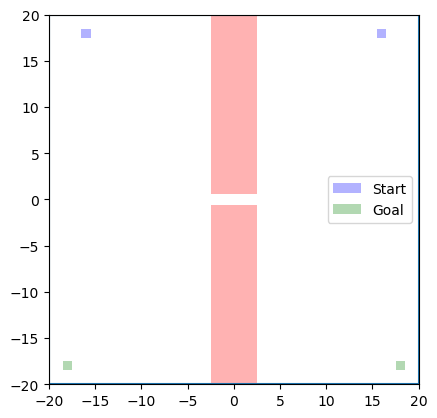

In [3]:
draw_env(env)

In [5]:
from panav.util import count_interger_var
from panav.conflict import plan_obs_conflict
class Lazy_Tube_Planning(Tube_Planning):
    def __init__(self, env, start, goal, vmax=1, bloating_r=0.5, d=2, t0=0, K_max=10, T_end_constraints=None, ignore_finished_agents=False, goal_reach_eps=None) -> None:
        super().__init__(env, start, goal, vmax, bloating_r, d, t0, K_max, T_end_constraints, ignore_finished_agents, goal_reach_eps)
        self.K =  self.K_max
        self.num_int_constraints = 0

    def plan(self,obstacle_trajectories=[],lazy=False):
        if lazy:
            return self.lazy_plan(obstacle_trajectories)
        else:
            t,x,_,prob = self.plan_core(
                                        
                                        
                                        obstacle_trajectories=obstacle_trajectories, # In non-lazy mode, we work with the entire set of obstacle trajectories
                                        
                                        
                                        solve_inplace = False)


            self.num_int_constraints = count_interger_var(prob)
            prob.solve(solver='GUROBI',TimeLimit = 100)
            if prob.status == 'optimal':
                p = (t.value[0,:],x.value)
                del prob
                return p
            else:
                return None
            
    
    def lazy_plan(self, obstacle_trajectories=[], return_all=True):
        '''
            Assuming the obstacle trajectories can be broken down into active segments.

            Lazily adding the active segments into the problem, resolve until the problem becomes feasible.

            In many cases, leads to faster solution due to less integer constraints.
        '''
        active_obs = []
        m = sum([len(o[0])-1 for o in obstacle_trajectories])

        i = 0
        while i<=m:
            t,x,_,prob = self.plan_core(
                
            
            
                                        active_obstacles=active_obs, # In lazy mode, we work with the active obstacles
                                            
                                            
                                        solve_inplace = False)
            


            self.num_int_constraints = count_interger_var(prob)
            prob.solve(solver='GUROBI',TimeLimit = 100)
            if prob.status == 'optimal':
                p = (t.value[0,:],x.value)
                del prob
            else:
                return None
            
            if p is None:
                print('MILP low-level encounters infeasibility.')
                break

            conflicted_obs = plan_obs_conflict(p, obstacle_trajectories, self.bloating_r, 
                                               segments_only=True, return_all=return_all)
            if not conflicted_obs:
                return p
            
            active_obs+=conflicted_obs
        return None
    
    def count_int_constraints(self,obstacle_trajectories=[]):
        return self.num_int_constraints

In [33]:
from panav.sequential import sequential_planning
Ks = np.arange(3,13)


from functools import partial

laziness = [True,False]
planner = Lazy_Tube_Planning

results = {}
for lazy in laziness:
    runtimes = []
    plans = []
    num_int_constraints = []
    for K in Ks:
        solver = partial(Lazy_Tube_Planning,K_max = K)
        p,rt,ni = sequential_planning(solver,env,vmax,bloating_r,
                                    TIMEOUT=1000,lazy=lazy,
                                    return_runtimes=True,return_int_constrains=True)
        runtimes.append(rt)
        plans.append(p)
        num_int_constraints.append(ni)
        print(K,ni)
    
    l = 'lazy' if lazy else 'not lazy'
    results[l] = dict(runtimes=runtimes,plans=plans,num_int_constraints=num_int_constraints)

Planning for agent 0/2
Planning for agent 1/2
3 [24, 60]
Planning for agent 0/2
Planning for agent 1/2
4 [32, 80]
Planning for agent 0/2
Planning for agent 1/2
5 [40, 100]
Planning for agent 0/2
Planning for agent 1/2
6 [48, 120]
Planning for agent 0/2
Planning for agent 1/2
7 [56, 140]
Planning for agent 0/2
Planning for agent 1/2
8 [64, 160]
Planning for agent 0/2
Planning for agent 1/2
9 [72, 180]
Planning for agent 0/2
Planning for agent 1/2
10 [80, 200]
Planning for agent 0/2
Planning for agent 1/2
11 [88, 220]
Planning for agent 0/2
Planning for agent 1/2
12 [96, 240]
Planning for agent 0/2
Planning for agent 1/2
3 [24, 147]
Planning for agent 0/2
Planning for agent 1/2
4 [32, 244]
Planning for agent 0/2
Planning for agent 1/2
5 [40, 365]
Planning for agent 0/2
Planning for agent 1/2
6 [48, 510]
Planning for agent 0/2
Planning for agent 1/2
7 [56, 679]
Planning for agent 0/2
Planning for agent 1/2
8 [64, 872]
Planning for agent 0/2
Planning for agent 1/2
9 [72, 1089]
Planning for

In [34]:
with open('./data/Laziness.pkl','wb') as fp:
    pkl.dump(dict(results=results),fp)

/var/folders/4v/bq7m33xj6b9fm2jfm0ngdg3c0000gn/T/ipykernel_58733/3888679501.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plans[key]=np.array(val['plans'])


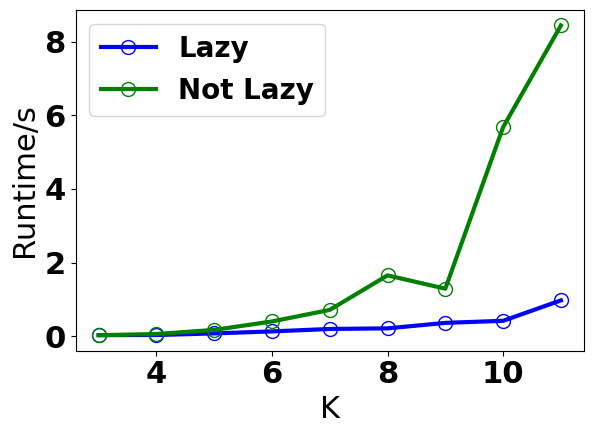

In [40]:
from matplotlib import pyplot as plt
from matplotlib import rc 
font = {'size'   : 22,'weight':'bold'}
rc('font', **font)
with open('./data/laziness.pkl','rb') as fp:
    results=pkl.load(fp)
    results = results['results']


runtimes = {}
num_int_constraints = {}
plans = {}
for key,val in results.items():
    runtimes[key]=np.array(val['runtimes'])
    num_int_constraints[key]=np.array(val['num_int_constraints'])
    plans[key]=np.array(val['plans'])

idx_to_plot = np.arange(len(Ks)-1)

color = {"lazy":'blue',
         "not lazy":'green'}
labels = {"lazy":"Lazy",
          'not lazy':'Not Lazy'}
n = 1
for key in ['lazy','not lazy']:
    RT = [rt[n] for rt in runtimes[key][idx_to_plot]]
    plt.plot(Ks[idx_to_plot],RT,
            marker = 'o',lw=3,markersize=10,markerfacecolor='none',label = labels[key],color=color[key])

plt.xlabel("K")
plt.ylabel("Runtime/s")
plt.legend(prop = dict(size = 20))
plt.tight_layout()
plt.savefig('./simFigures/Laziness/runtime.pdf')

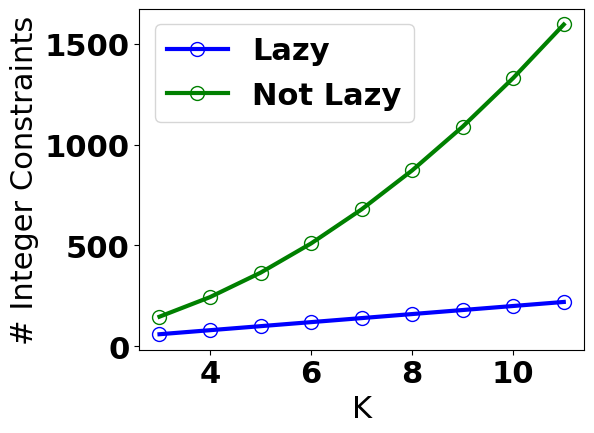

In [36]:
n = 1
for key in ['lazy','not lazy']:
    plt.plot(Ks[idx_to_plot],[nums[n] for nums in num_int_constraints[key][idx_to_plot]],
            marker = 'o',lw=3,markersize=10,markerfacecolor='none',label = labels[key],color=color[key])


plt.xticks(np.arange(4,11,2),np.arange(4,11,2))
plt.xlabel("K")
plt.ylabel("# Integer Constraints")
plt.legend()

plt.tight_layout()
plt.savefig('./simFigures/Laziness/num_int_constraints.pdf')